In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../../../IRL22SU/FE/FeT_1cm_2324_2325/*.txt')
files

#here is where the output will go 
path2 = '../../../IRL22SU/FE/FeT_1cm_2324_2325.csv'
files

['../../../IRL22SU/FE/FeT_1cm_2324_2325\\0000_uM_Absorbance__0__17.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\0010_uM_Absorbance__0__18.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\0050_uM_Absorbance__0__19.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\0100_uM_Absorbance__0__20.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\0300_uM_Absorbance__0__21.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\1000_uM_Absorbance__0__22.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\232402_Absorbance__0__33.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\232405_Absorbance__0__32.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\232427_Absorbance__0__23.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\232433_Absorbance__0__24.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\232501_Absorbance__0__34.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\232513_Absorbance__0__35.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\232514_Absorbance__0__36.txt',
 '../../../IRL22SU/FE/FeT_1cm_2324_2325\\232522_Absorbance

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index
df

,0000_uM_Absorbance__0__17.txt,0010_uM_Absorbance__0__18.txt,0050_uM_Absorbance__0__19.txt,0100_uM_Absorbance__0__20.txt,0300_uM_Absorbance__0__21.txt,1000_uM_Absorbance__0__22.txt,232402_Absorbance__0__33.txt,232405_Absorbance__0__32.txt,232427_Absorbance__0__23.txt,232433_Absorbance__0__24.txt,...,232513_Absorbance__0__35.txt,232514_Absorbance__0__36.txt,232522_Absorbance__0__25.txt,232524_Absorbance__0__26.txt,232528_Absorbance__0__27.txt,232530_Absorbance__0__28.txt,232532_Absorbance__0__29.txt,232534_Absorbance__0__30.txt,232536_Absorbance__0__31.txt,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,0.369323,-0.017925,-0.003707,0.372061,-0.001754,-0.003748,0.108750,0.103214,0.383236,-0.005253,...,0.000292,-0.177218,0.193893,-0.001114,-0.187586,-0.072647,-0.244401,0.584506,0.072261,189
190,0.369323,-0.017925,-0.003707,0.372061,-0.001754,-0.003748,0.108750,0.103214,0.383236,-0.005253,...,0.000292,-0.177218,0.193893,-0.001114,-0.187586,-0.072647,-0.244401,0.584506,0.072261,190
191,-0.119064,-0.196655,-0.003707,0.057897,-0.023134,0.038318,-0.081383,-0.000886,-0.385798,0.199189,...,0.247769,-0.085265,-0.521178,-0.194688,-0.217230,0.003753,0.473317,-0.034892,0.328037,191
192,0.024575,-0.005623,0.042065,-0.270044,0.183934,0.260079,-0.448247,-0.579169,-0.359080,-0.450501,...,-0.211501,-0.016084,-0.590092,0.626314,-0.098410,-0.509068,0.646271,-0.837939,0.122060,192
193,0.044530,1.286789,-0.003707,-0.001639,0.056998,-0.003748,0.047419,-0.000886,-0.001464,-0.005253,...,0.000292,-0.003118,-0.005907,-0.001114,-0.032089,0.003753,-0.068284,0.002506,0.008661,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.003393,0.006470,0.004948,0.003069,0.003978,0.008375,0.007069,0.002528,0.004152,0.004021,...,0.005794,0.006136,0.007226,0.005846,0.006500,0.005151,0.004963,0.004489,0.005308,876
877,0.009047,0.007213,0.005263,0.008105,0.006888,0.011863,0.008801,0.007510,0.002762,0.005974,...,0.008082,0.007897,0.007926,0.010507,0.008223,0.005721,0.006351,0.007332,0.008258,877
878,0.008476,0.009568,0.008034,0.002626,0.010151,0.010925,0.009382,0.009507,0.007539,0.007304,...,0.009158,0.008123,0.011214,0.010272,0.012665,0.005048,0.009589,0.007047,0.005113,878


In [5]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=7).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,0000,0010,0050,0100,0300,1000,232402,232405,232427,232433,...,232513,232514,232522,232524,232528,232530,232532,232534,232536,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,0.369323,-0.017925,-0.003707,0.372061,-0.001754,-0.003748,0.108750,0.103214,0.383236,-0.005253,...,0.000292,-0.177218,0.193893,-0.001114,-0.187586,-0.072647,-0.244401,0.584506,0.072261,189
190,0.369323,-0.017925,-0.003707,0.372061,-0.001754,-0.003748,0.108750,0.103214,0.383236,-0.005253,...,0.000292,-0.177218,0.193893,-0.001114,-0.187586,-0.072647,-0.244401,0.584506,0.072261,190
191,-0.119064,-0.196655,-0.003707,0.057897,-0.023134,0.038318,-0.081383,-0.000886,-0.385798,0.199189,...,0.247769,-0.085265,-0.521178,-0.194688,-0.217230,0.003753,0.473317,-0.034892,0.328037,191
192,0.024575,-0.005623,0.042065,-0.270044,0.183934,0.260079,-0.448247,-0.579169,-0.359080,-0.450501,...,-0.211501,-0.016084,-0.590092,0.626314,-0.098410,-0.509068,0.646271,-0.837939,0.122060,192
193,0.044530,1.286789,-0.003707,-0.001639,0.056998,-0.003748,0.047419,-0.000886,-0.001464,-0.005253,...,0.000292,-0.003118,-0.005907,-0.001114,-0.032089,0.003753,-0.068284,0.002506,0.008661,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.003393,0.006470,0.004948,0.003069,0.003978,0.008375,0.007069,0.002528,0.004152,0.004021,...,0.005794,0.006136,0.007226,0.005846,0.006500,0.005151,0.004963,0.004489,0.005308,876
877,0.009047,0.007213,0.005263,0.008105,0.006888,0.011863,0.008801,0.007510,0.002762,0.005974,...,0.008082,0.007897,0.007926,0.010507,0.008223,0.005721,0.006351,0.007332,0.008258,877
878,0.008476,0.009568,0.008034,0.002626,0.010151,0.010925,0.009382,0.009507,0.007539,0.007304,...,0.009158,0.008123,0.011214,0.010272,0.012665,0.005048,0.009589,0.007047,0.005113,878


Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

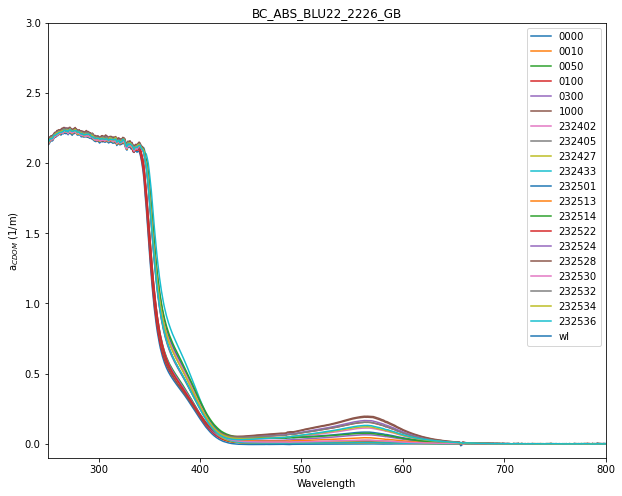

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("BC_ABS_BLU22_2226_GB")


In [7]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')
ss_outs.to_csv(path2)

ss_outs['conc'] = ss_outs.index.astype(int)
ss_outs

,abs_562,intagration,conc
sample,,,
0000,-0.000451,-0.365064,0
0010,0.004128,0.659605,10
0050,0.011651,1.396328,50
0100,0.019433,2.199351,100
0300,0.064280,7.007407,300
1000,0.189521,20.603581,1000
232402,0.112141,12.142071,232402
232405,0.019897,2.429950,232405
232427,0.024128,2.561197,232427


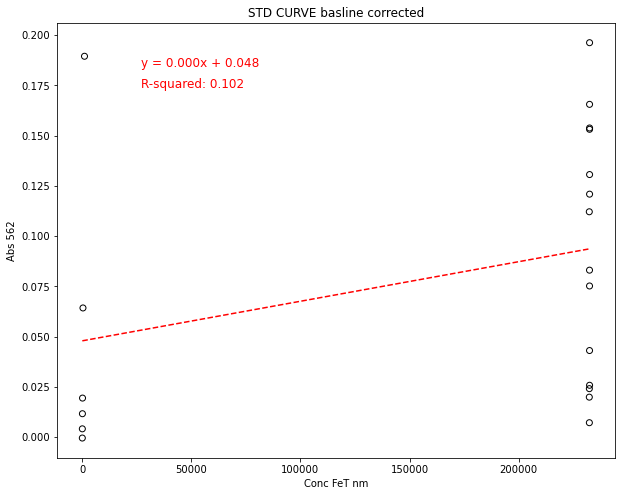

In [8]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ss_outs['conc'], ss_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = ss_outs['conc']
y = ss_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


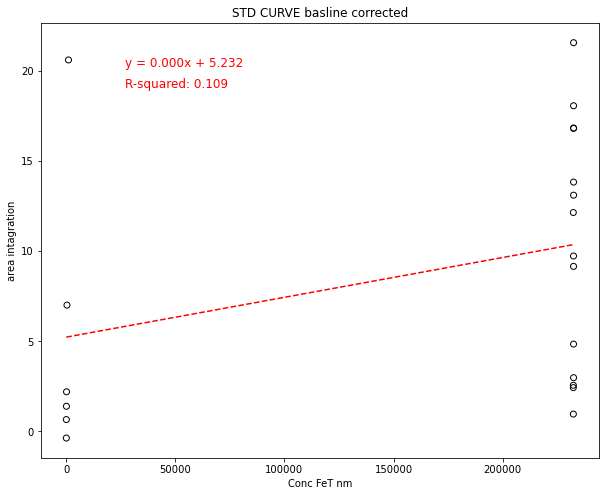

In [9]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ss_outs['conc'], ss_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = ss_outs['conc']
y = ss_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

EXPERIMENTAL